In [1]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
import numpy as np
import corner

/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


# Galaxy-galaxy simulations

This notebook walks through the basics of simulating a galaxy-galaxy strong lensing population.
The underlying 

assumptions of the galaxy populations (for both lenses and sources) are drawn from a population pre-configured

 and rendered through [SkyPy](https://github.com/skypyproject/skypy). The specific settings are described in the [readme file](https://github.com/LSST-strong-lensing/slsim/tree/gg-lensing/data/SkyPy).

The notebook goes in three steps:

1. The populations of lenses and sources is produced.
2. Random draws of the population are generated and realized as images
3. The full population is generated in catalogue form
4. the full population is represented in a corner plot



## Generate population of galaxies and (potential) deflectors
The LensPop() class in the slsim package is used to produce a set of galaxies (as lenses and sources)

as seen on the sky within a certain sky area.
We use the default SkyPy configuration file. Alternative configuration

files can be used.

In [2]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = Quantity(value=0.1, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

# run skypy pipeline and make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_type="all-galaxies",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=None,
    sky_area=sky_area,
    cosmo=cosmo,
    return_kext=True,
    los_bool=True,
    nonlinear_los_bool=True,
)

## Generate images of random lenses
The LensingPlots() class has the functionality to draw random lenses and makes an image of it.
Currently

default settings in lenstronomy are chosen for the LSST image settings. These will be able to be replaced with the

LSST simulation tools.

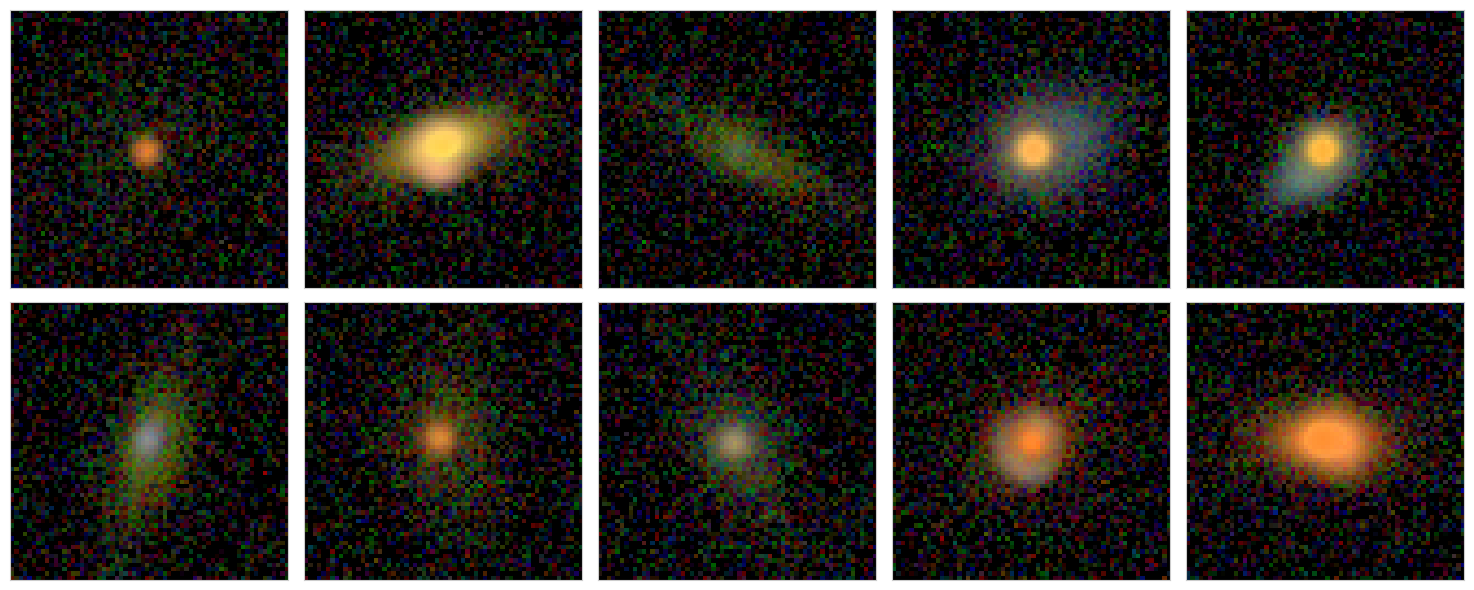

In [3]:
# make some cuts in the image separations and limited magnitudes of the arc
kwargs_lens_cut_plot = {
    "min_image_separation": 0.8,
    "max_image_separation": 10,
    "mag_arc_limit": {"g": 23, "r": 23, "i": 23},
}


gg_plot = LensingPlots(gg_lens_pop, num_pix=64, coadd_years=10)

# generate montage indicating which bands are used for the rgb color image
fig, axes = gg_plot.plot_montage(
    rgb_band_list=["i", "r", "g"],
    add_noise=True,
    n_horizont=5,
    n_vertical=2,
    kwargs_lens_cut=kwargs_lens_cut_plot,
)
plt.show()

## Generate the full population
We are using the instance of the LensPop() class to draw the full population within specified cuts in a Monte Carlo process.

In [4]:
# specifying cuts of the population
kwargs_lens_cuts = {"mag_arc_limit": {"g": 28},
    "min_image_separation": 1,
    "max_image_separation": 10,}
# drawing population
gg_lens_population, kappa_ext_origin = gg_lens_pop.draw_population(kwargs_lens_cuts=kwargs_lens_cuts)

## Represent key quantities of full population in corner plots
We calculate few key quantities of the lenses. The full population is represented each with a Lens() class

object that allows to compute and return these (and more) quantities.

In [5]:
print("Number of lenses:", len(gg_lens_population))

lens_samples = []
external_kappa = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
    r"$\kappa_{\rm ext}$",
    r"$\gamma_{\rm ext}$",
]

for gg_lens in gg_lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    theta_e = gg_lens.einstein_radius
    zl = gg_lens.deflector_redshift
    zs = gg_lens.source_redshift
    source_mag = gg_lens.extended_source_magnitude(band="g", lensed=True)
    deflector_mag = gg_lens.deflector_magnitude(band="g")
    kappa = gg_lens.external_convergence()
    gamma = gg_lens.external_shear()
    lens_samples.append(
        [vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag, kappa, gamma]
    )
    external_kappa.append(gg_lens.external_convergence())

Number of lenses: 898


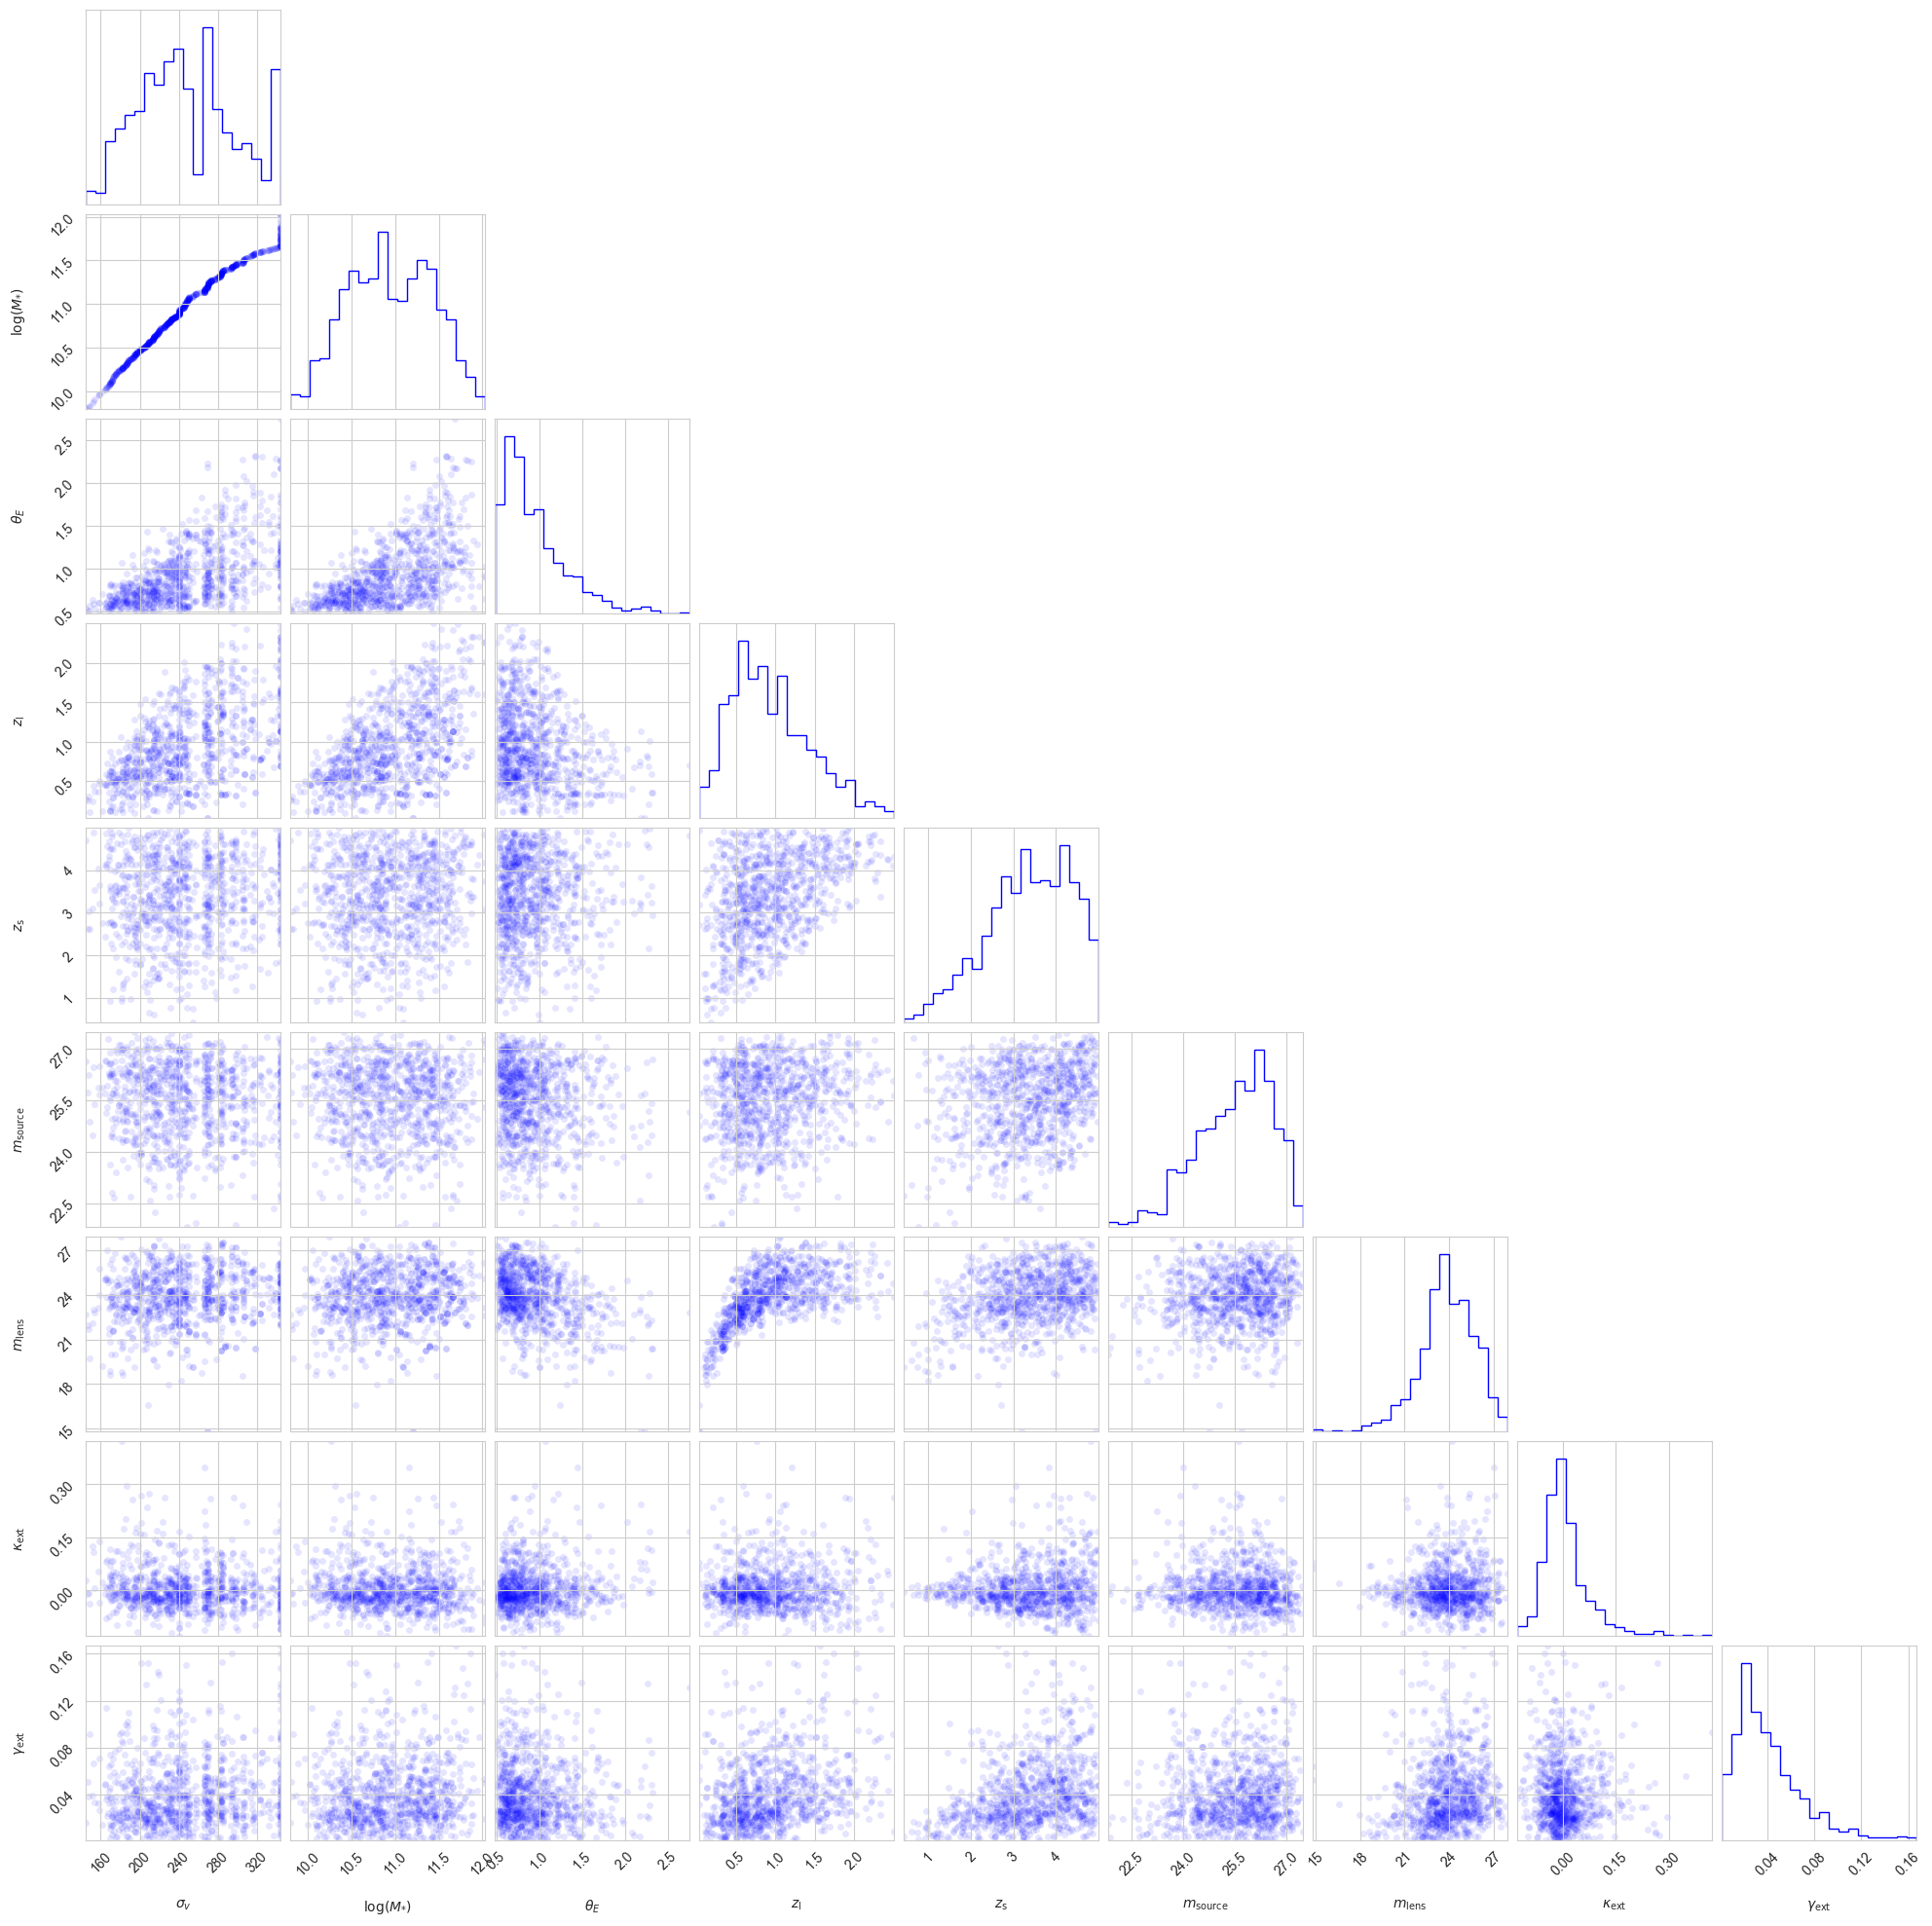

In [6]:
hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
corner.corner(np.array(lens_samples), labels=labels, **hist2dkwargs)
plt.show()

In [7]:
gg_lens_pop_without_los = LensPop(
    deflector_type="all-galaxies",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=None,
    sky_area=sky_area,
    los_bool=False,
    cosmo=cosmo,
)
gg_lens_population_without_los = gg_lens_pop_without_los.draw_population(kwargs_lens_cuts=kwargs_lens_cuts)

In [8]:
lens_samples_no_los=[]
for gg_lens_no_los in gg_lens_population_without_los:
    vel_disp_no_los = gg_lens_no_los.deflector_velocity_dispersion()
    m_star_no_los = gg_lens_no_los.deflector_stellar_mass()
    theta_e_no_los = gg_lens_no_los.einstein_radius
    zl_no_los = gg_lens_no_los.deflector_redshift
    zs_no_los = gg_lens_no_los.source_redshift
    source_mag_no_los = gg_lens_no_los.extended_source_magnitude(band="g", lensed=True)
    deflector_mag_no_los = gg_lens_no_los.deflector_magnitude(band="g")
    kappa_no_los = gg_lens_no_los.external_convergence()
    gamma_no_los = gg_lens_no_los.external_shear()
    
    lens_samples_no_los.append(
        [vel_disp_no_los, np.log10(m_star_no_los), theta_e_no_los, zl_no_los, zs_no_los, source_mag_no_los, deflector_mag_no_los]
    )


In [9]:
lens_samples_withlos = []
for gg_lens in gg_lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    theta_e = gg_lens.einstein_radius
    zl = gg_lens.deflector_redshift
    zs = gg_lens.source_redshift
    source_mag = gg_lens.extended_source_magnitude(band="g", lensed=True)
    deflector_mag = gg_lens.deflector_magnitude(band="g")
    lens_samples_withlos.append(
        [vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag]
    )

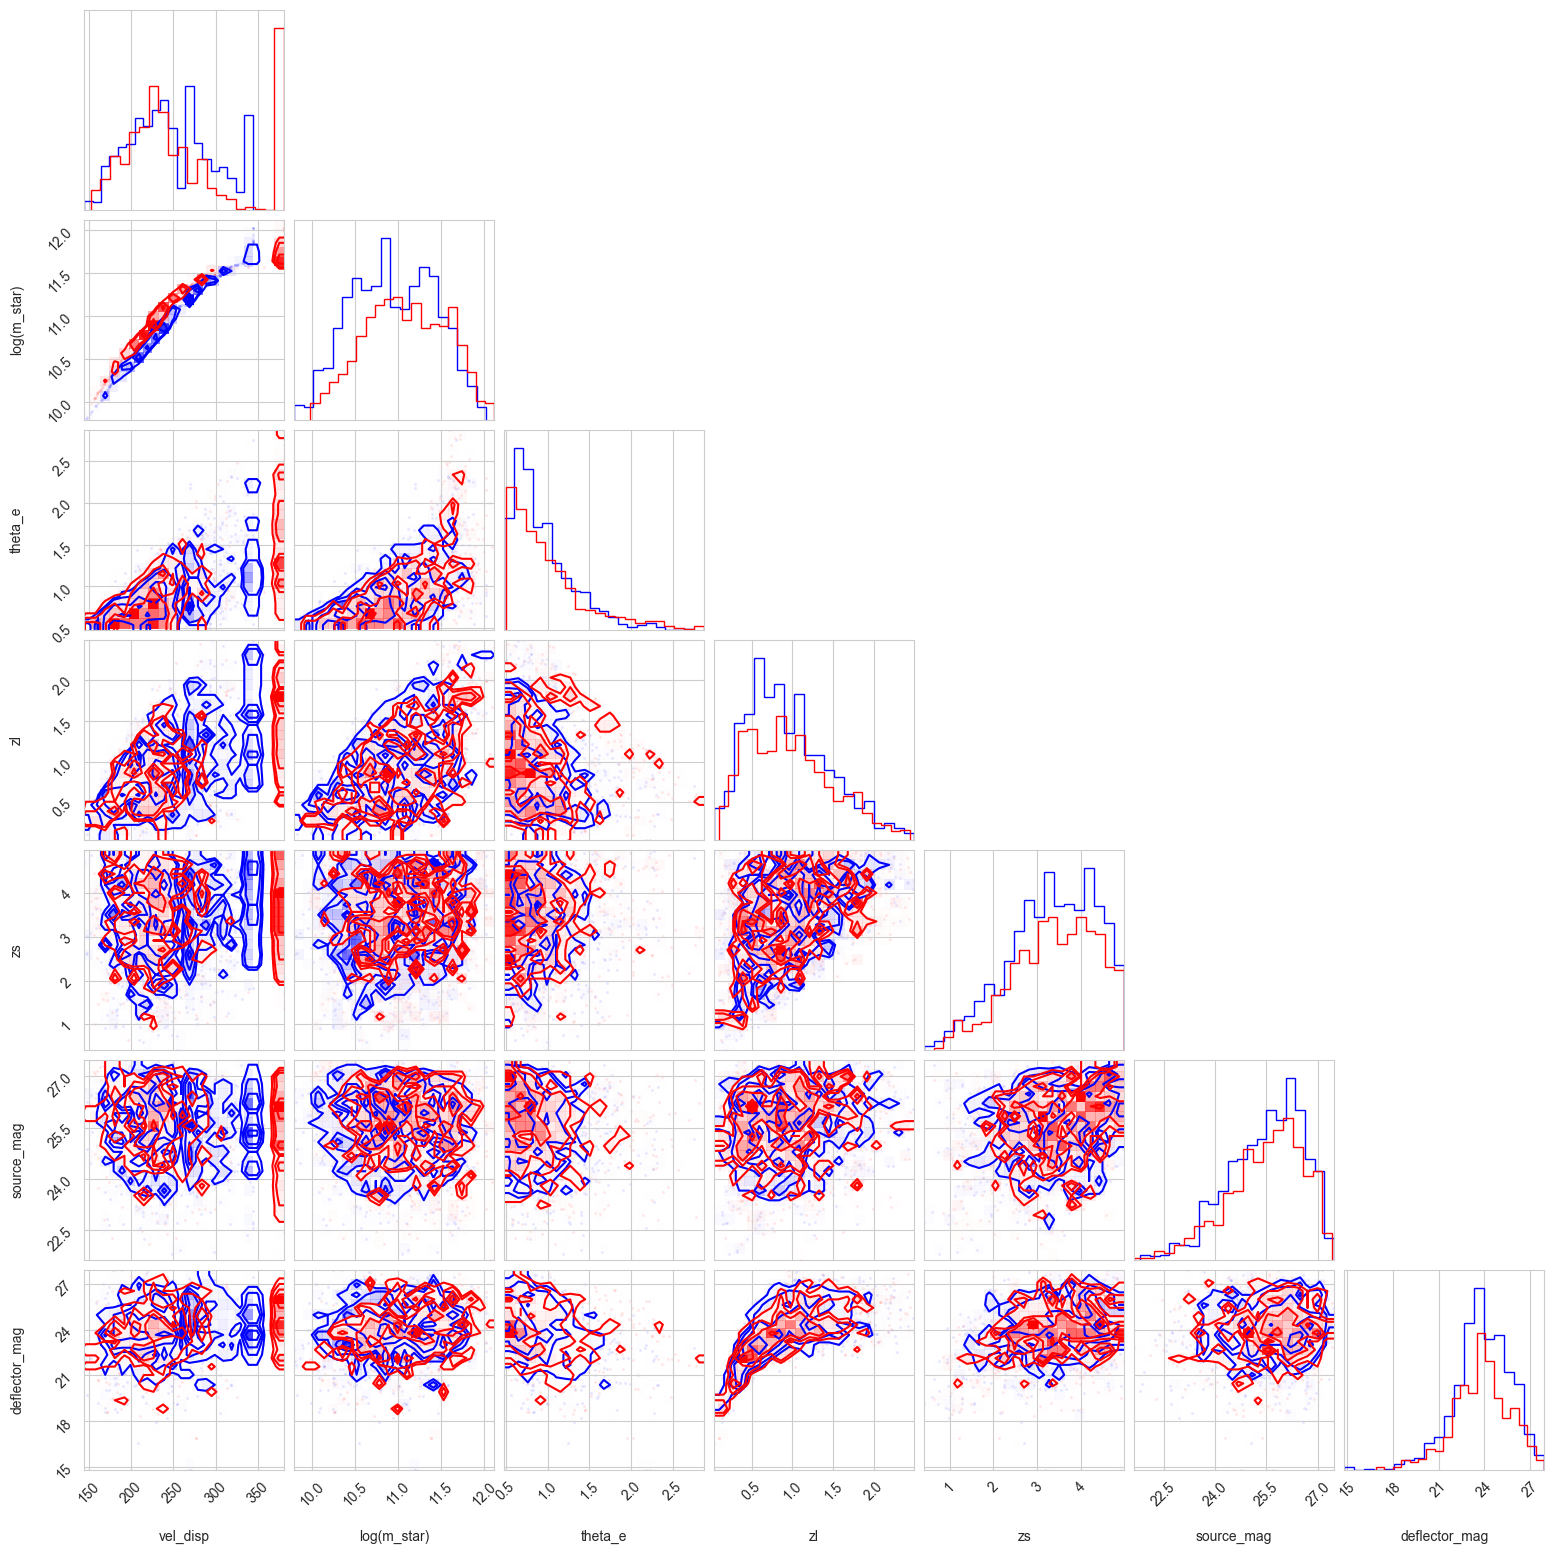

In [10]:
lens_samples_array = np.array(lens_samples_withlos)
lens_samples_no_los_array = np.array(lens_samples_no_los)

labels = ["vel_disp", "log(m_star)", "theta_e", "zl", "zs", "source_mag", "deflector_mag"]

fig = corner.corner(lens_samples_array, labels=labels, color='blue', 
                    plot_datapoints=True, plot_density=True, plot_contours=True)

corner.corner(lens_samples_no_los_array, labels=labels, color='red', 
              plot_datapoints=True, plot_density=True, plot_contours=True, fig=fig)

plt.show()



In [11]:
print(external_kappa)

[0.144069813382823, -0.00477557313835749, 0.003632404516297035, 0.03983505335817881, -0.05202289501875562, 0.003909182094774404, 0.0001279440241097364, -0.014551223949444471, 0.003470880588444015, -0.04088571539330506, 0.006769942681063169, -0.02423036515245097, -0.03326286788802174, -0.0006617125910909115, -0.029721152163979365, -0.10126145031933112, -0.024949866560905254, 0.017601721269312927, 0.07321834784026933, 0.030030313473285813, 0.03373393271845134, -0.06514818602267654, -0.04349982050736947, -0.016617618843733126, -0.013120574095719026, 0.008138513282564364, -0.011411185475664592, -0.038438148253559144, 0.035553426445194006, -0.03015737126673415, 0.031009487728875743, -0.0057630917927418805, -0.00558560010131825, 0.01893267663302628, 0.08972044292508204, 0.03940883009133564, 0.03983661167590959, -0.015523958597175851, 0.1044102757674032, -0.020846530684285835, -0.005273512347928867, -0.06654044341390204, 0.1393855362056049, -0.044230110227693416, -0.018394360500735306, 0.0202

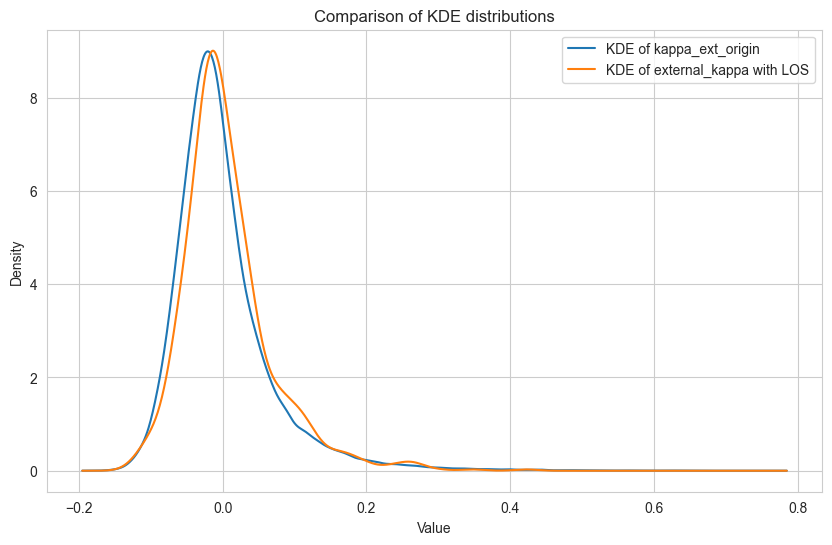

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

kappa_ext_origin_array = np.array(kappa_ext_origin)
external_kappa_array = np.array(external_kappa)

kde_kappa_ext_origin = gaussian_kde(kappa_ext_origin_array)
kde_external_kappa = gaussian_kde(external_kappa_array)

x_min = min(kappa_ext_origin_array.min(), external_kappa_array.min())
x_max = max(kappa_ext_origin_array.max(), external_kappa_array.max())
x = np.linspace(x_min, x_max, 1000)
density_kappa_ext_origin = kde_kappa_ext_origin(x)
density_external_kappa = kde_external_kappa(x)

plt.figure(figsize=(10, 6))
sns.lineplot(x=x, y=density_kappa_ext_origin, label='KDE of kappa_ext_origin')
sns.lineplot(x=x, y=density_external_kappa, label='KDE of external_kappa with LOS')
plt.title('Comparison of KDE distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [13]:
mean_kappa_ext_origin = np.mean(kappa_ext_origin_array)
mean_external_kappa = np.mean(external_kappa_array)

In [14]:
mean_change = mean_external_kappa - mean_kappa_ext_origin
mean_change

0.006800339630382461

In [15]:
gg_lens_pop_no_nonlinear = LensPop(
    deflector_type="all-galaxies",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=None,
    sky_area=sky_area,
    los_bool=True,
    nonlinear_los_bool=False,
    return_kext=True,
    cosmo=cosmo,
)
gg_lens_population_no_nonlinear,oringin_kappa_no_nl = gg_lens_pop_no_nonlinear.draw_population(kwargs_lens_cuts=kwargs_lens_cuts)

In [16]:
lens_samples_no_nonlinear=[]
external_kappa_no_nonlinear = []
for gg_lens_no_nonlinear in gg_lens_population_no_nonlinear:
    vel_disp_no_nonlinear = gg_lens_no_nonlinear.deflector_velocity_dispersion()
    m_star_no_nonlinear = gg_lens_no_nonlinear.deflector_stellar_mass()
    theta_e_no_nonlinear = gg_lens_no_nonlinear.einstein_radius
    zl_no_nonlinear = gg_lens_no_nonlinear.deflector_redshift
    zs_no_nonlinear = gg_lens_no_nonlinear.source_redshift
    source_mag_no_nonlinear = gg_lens_no_nonlinear.extended_source_magnitude(band="g", lensed=True)
    deflector_mag_no_nonlinear = gg_lens_no_nonlinear.deflector_magnitude(band="g")
    kappa_no_nonlinear = gg_lens_no_nonlinear.external_convergence()
    gamma_no_nonlinear = gg_lens_no_nonlinear.external_shear()
    external_kappa_no_nonlinear.append(gg_lens_no_nonlinear.external_convergence())

    lens_samples_no_nonlinear.append(
        [vel_disp_no_nonlinear, np.log10(m_star_no_nonlinear), theta_e_no_nonlinear, zl_no_nonlinear, zs_no_nonlinear, source_mag_no_nonlinear, deflector_mag_no_nonlinear,kappa_no_nonlinear, gamma_no_nonlinear]
    )

In [17]:
mean_kappa_no_nonlinear = np.mean(external_kappa_no_nonlinear)
oringin_kappa_array_nl = np.array(oringin_kappa_no_nl)
mean_oringin_kappa_nl = np.mean(oringin_kappa_array_nl)

mean_change_no_nonlinear = mean_kappa_no_nonlinear - mean_oringin_kappa_nl
mean_change_no_nonlinear

0.00933598357098141

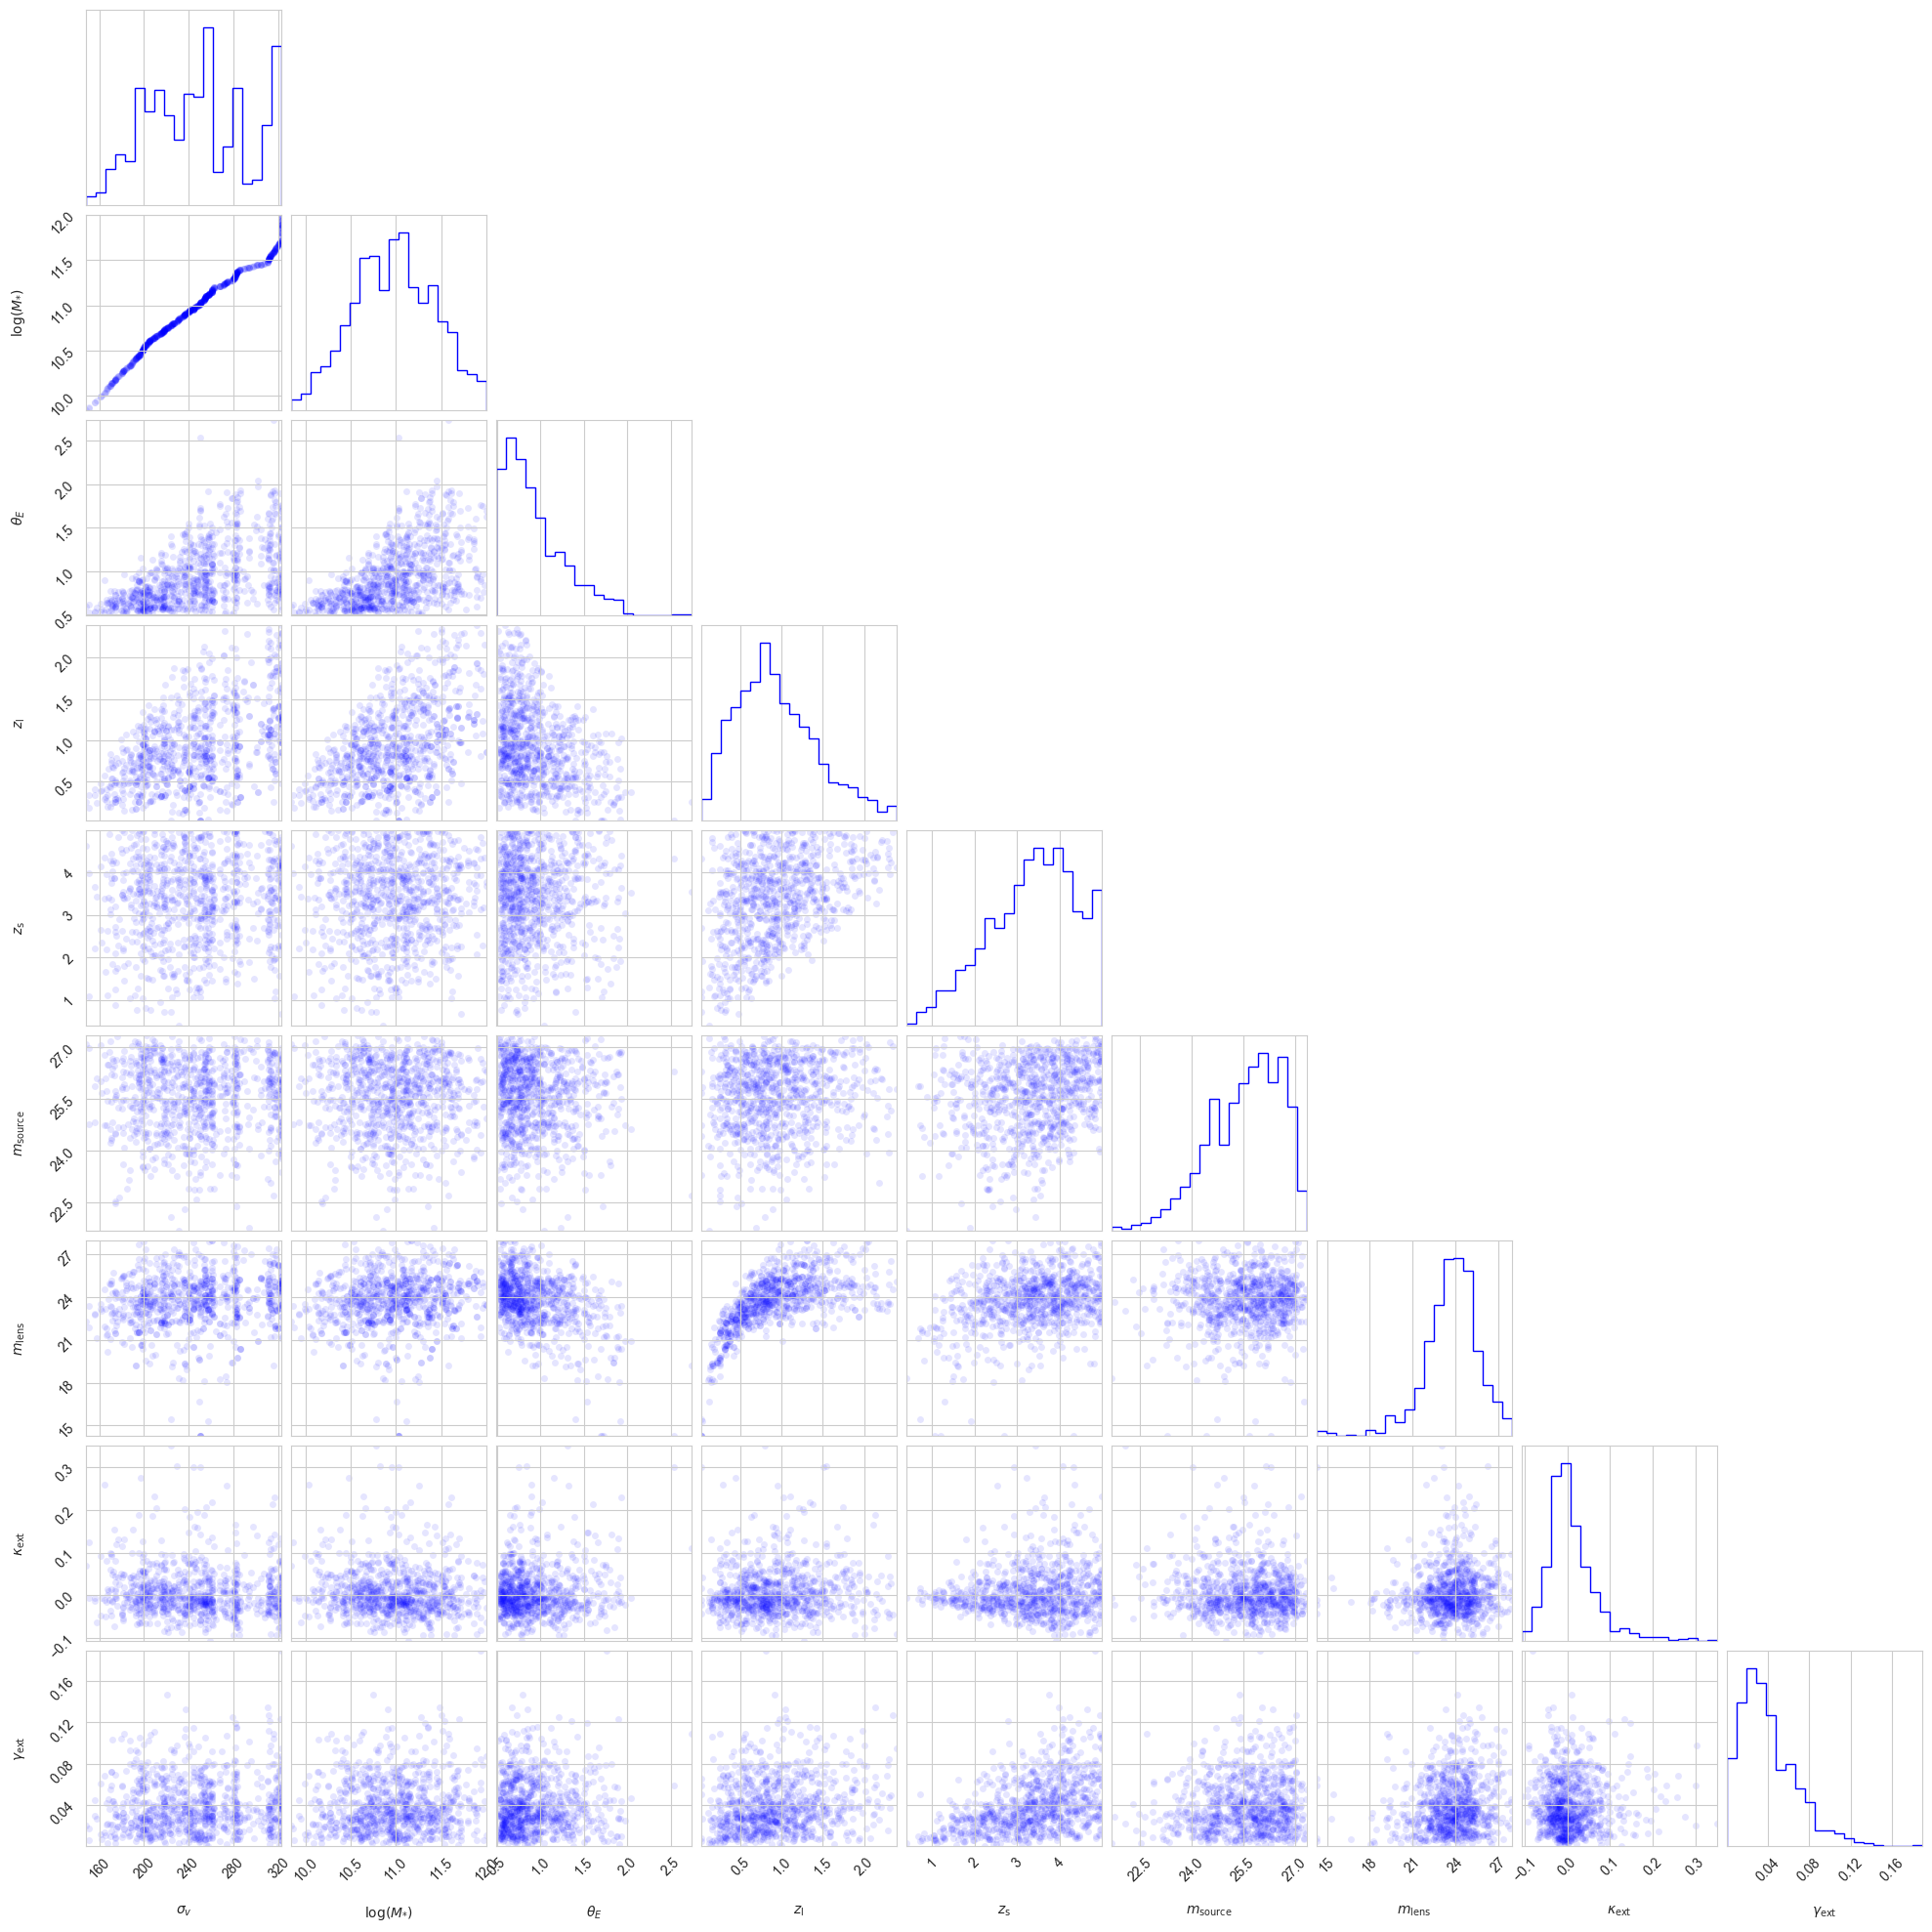

In [18]:
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
    r"$\kappa_{\rm ext}$",
    r"$\gamma_{\rm ext}$",
]
corner.corner(np.array(lens_samples_no_nonlinear), labels=labels, **hist2dkwargs)
plt.show()

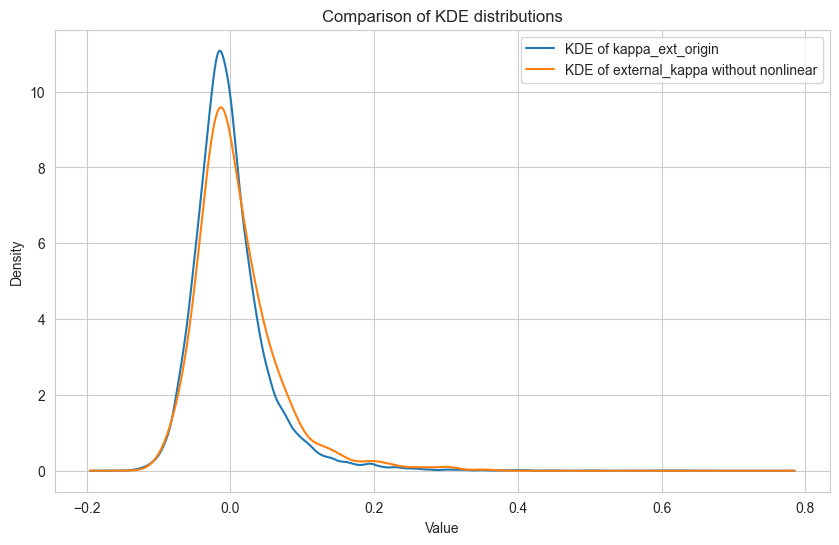

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde


kappa_no_nonlinear_array = np.array(external_kappa_no_nonlinear)

kde_kappa_ext_origin = gaussian_kde(oringin_kappa_array_nl)
kde_no_nonlinear = gaussian_kde(kappa_no_nonlinear_array)


x_min = min(kappa_ext_origin_array.min(), kappa_no_nonlinear_array.min())
x_max = max(kappa_ext_origin_array.max(), kappa_no_nonlinear_array.max())

x = np.linspace(x_min, x_max, 1000)
density_kappa_ext_origin = kde_kappa_ext_origin(x)
density_no_nonlinear = kde_no_nonlinear(x)

plt.figure(figsize=(10, 6))
sns.lineplot(x=x, y=density_kappa_ext_origin, label='KDE of kappa_ext_origin')
sns.lineplot(x=x, y=density_no_nonlinear, label='KDE of external_kappa without nonlinear')
plt.title('Comparison of KDE distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [20]:
print(external_kappa_no_nonlinear)

[0.030349386582599343, 0.006543223172975604, -0.0010662831108841416, 0.002804054501549337, -0.017232130873402147, -0.03529755921816081, 0.042092548634211, 0.015257848770015348, -0.00305606686681034, 0.044250064960021124, 0.18632690642335112, 0.0027744160587552594, -0.00990071743331358, -0.020482563514079254, 0.05948884436512315, -0.07634768762663638, 0.04058426577605468, -0.015913106529049925, -0.04620399367006302, 0.13096477122192735, 0.010199889413912573, -0.002617717033319605, -0.024358254375006022, 0.003222945836620989, 0.0456144497357159, 0.08979669301915029, -0.018299562890961123, 0.007368382790329704, -0.045582636939855564, -0.019254608160257057, -0.02332636965350607, -0.022603203906902184, 0.014150582542080806, 0.012425518554171164, 0.35113448856322294, 0.14817395981181342, -0.06818424819592638, 0.05606647370002761, 0.10397820475537406, -0.023597398120469626, -0.039308207750522225, 0.0007442608867323369, -0.04230798536234713, -0.06009095261264983, 0.04067822535359942, 0.0302316

In [21]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = Quantity(value=0.01, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

# run skypy pipeline and make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_type="all-galaxies",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=None,
    sky_area=sky_area,
    cosmo=cosmo,
    return_kext=True,
    los_bool=True,
    nonlinear_los_bool=True,
)

kwargs_lens_cuts = {"mag_arc_limit": {"g": 28},
    "min_image_separation": 0.9,
    "max_image_separation": 10,}

#case1, case1_quad, case1_double, case2, case2_quad, case2_double, case3, case3_quad, case3_double, total_number=gg_lens_pop.compare_quad#(kwargs_lens_cuts=kwargs_lens_cuts)
#case1：WIthout LOS
#case2: With LOS but without nonlinear correction
#case3: With LOS and nonlinear correction

In [22]:
case1, case1_quad, case1_double, case2, case2_quad, case2_double, case3, case3_quad, case3_double, total_number = gg_lens_pop.compare_quad_muiltprocess(kwargs_lens_cuts=kwargs_lens_cuts)

num_lenses 4711


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

In [23]:
print(case1, case1_quad, case1_double, case2, case2_quad, case2_double, case3, case3_quad, case3_double, total_number)
print(case1_quad/case1_double, case2_quad/case2_double, case3_quad/case3_double)

928 37 891 919 40 878 932 45 887 0
0.04152637485970819 0.04555808656036447 0.05073280721533258
